# Определение стоимости автомобилей

**Задача:** Построить модель для определения стоимости автомобилей.   
**Цель:** Приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.   
**Дано:** исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Импорты**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from catboost import cv
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

**Знакомство с датасетом**

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
print('Исходный датасет')
print(f'Количество строк {data.shape[0]}')
print(f'Количество столбцов {data.shape[1]}')

Исходный датасет
Количество строк 354369
Количество столбцов 16


**Дубликаты**

In [5]:
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 4


In [6]:
data = data.drop_duplicates()
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 0


На данном этапе выявлено всего 4 дубликата на 354к строчек.Не типично для датасета такого размера, исследуем этот вопрос далее. 

**Общая информация**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

В исходном датасете 15 признаков, часть из которых относится непосредственно к автомобилю, другая часть к самому обьявлению или его автору. 

**Пропуски**

In [8]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('bwr')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.600000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.600000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.300000


Больше всего пропусков в признаке **Repaired**. Причина пропусков может быть разной, от введения данного признака уже после запуска платформы, до технических ошибок.

На втором месте по пропускам **VehicleType**. Возможно техническая ошибка.

**FuelType, Gearbox, Model** -  5-9% пропусков - тип топлива, коробка передач и модель. Доля пропусков в последних двух признаков одинакова. Рассмотрим подобные примеры ниже.

Заменим пропуски на "no info".

In [9]:
nans = ['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']
data[nans] = data[nans].fillna('no info')

In [10]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('plasma')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


**Корреляция**

In [11]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


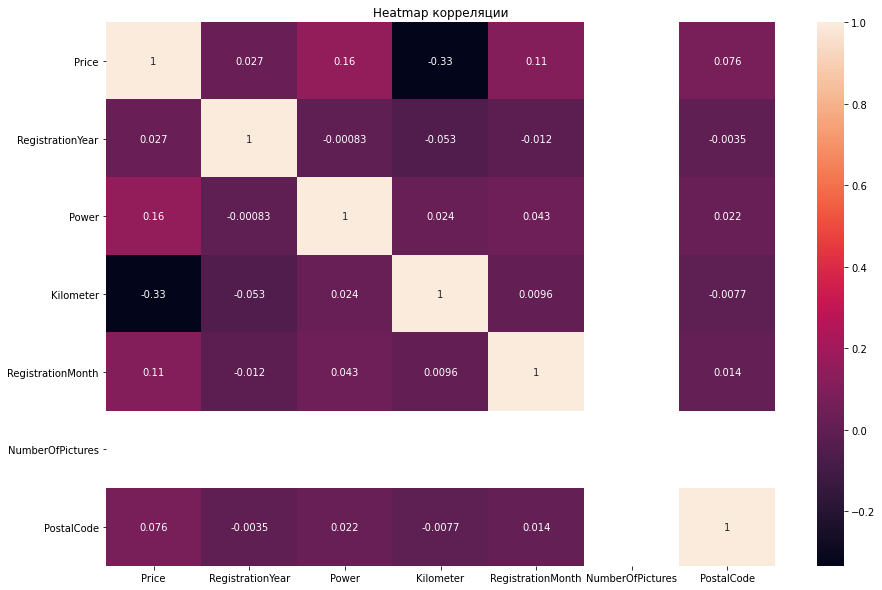

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True)
plt.title('Heatmap корреляции')
plt.show()

На первый взгляд какой-то явной корреляция не выявлено.
Библиотеку PHIK использовать не удалось, вероятно из-за размеров датасета и ограничений мощности jupyterhyb.

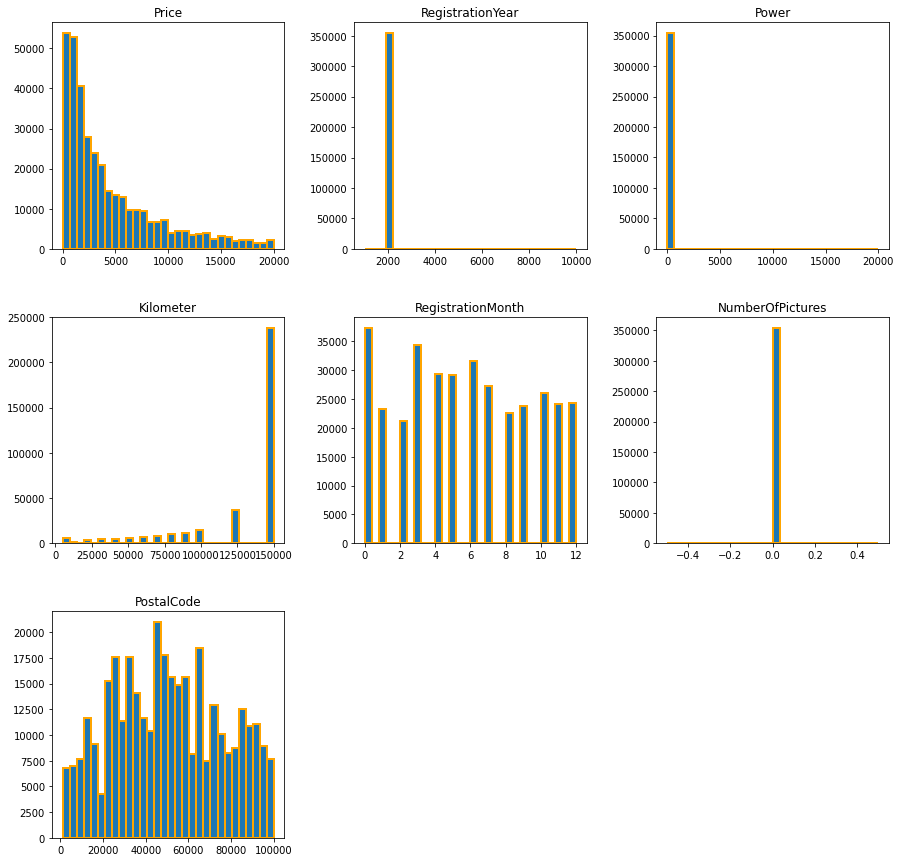

In [13]:
data.hist(bins=30, figsize=(15,15), edgecolor='orange', grid=False, linewidth=2)
plt.show()

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
Kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.503800,25783.100078,1067.0,30165.0,49413.0,71083.0,99998.0


Аномальные значения по min и max году, мощности. Попробуем отфильтровать их с помощью квантилей.

In [15]:
cols_clean = ['Price', 'Power', 'RegistrationYear']
low = .01
high = .99
quant_df = data[cols_clean].quantile([low, high])
data_clean = data[cols_clean].apply(lambda x: x[(x > quant_df.loc[low, x.name]) & 
                                     (x < quant_df.loc[high, x.name])], axis=0)
data_clean.dropna(inplace=True)
data_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,295309.0,4569.945962,4282.808988,1.0,1299.0,2999.0,6600.0,18799.0
Power,295309.0,117.495017,48.042445,1.0,75.0,110.0,145.0,299.0
RegistrationYear,295309.0,2003.344341,6.179831,1981.0,1999.0,2003.0,2007.0,2017.0


In [16]:
data.shape

(354365, 16)

Удалось получить минимальный год 1972 и максимальный 2017, что выглядит более реальным. Создадим отдельный датасет без аномалий.

In [17]:
auto_q = data[data.index.isin(data_clean.index)]
auto_q.head(7)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,no info,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no info,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no info,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13


In [18]:
auto_q.shape

(295309, 16)

In [19]:
auto_q.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Разделим признаки на те, что относятся к авто и к самому обьявлению.

**Признаки**

- DateCrawled — дата скачивания обьявления	📑
- VehicleType — тип  кузова  🚘
- RegistrationYear — год регистрации 	📑
- Gearbox — тип коробки передач  🚘
- Power — мощность (л.с.)  🚘
- Model — модель 🚘
- Kilometer — пробег (км)  🚘
- RegistrationMonth — месяц регистрации автомобиля	📑
- FuelType — тип топлива 🚘
- Brand — марка 🚘
- Repaired — кузовной ремонт 🚘
- DateCreated — дата создания обьявления	📑
- NumberOfPictures — количество фотографий авто	📑
- PostalCode — почтовый индекс владельца авто	📑
- LastSeen — дата последней активности владельца  	📑

**Целевой признак**

- Price — цена (евро) 💰

Уберём те признаки обьявления, которые имеют минимальную информативность в части формирования цены.

In [55]:
cols = ['DateCrawled', 'RegistrationMonth','DateCreated', 
        'NumberOfPictures', 'PostalCode', 'LastSeen']
df = auto_q.drop(cols, axis=1)
df.head(7)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,no info,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no info


In [56]:
mydups = df.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 38956


В результате удаление признаков по обьявлению выявилось дополнительно 39к полных дупликатов. Это могут быть повторное выставление на продажу одной и той же машины или массовая продажа одинаковых машин, автосалоном. Эту информацию следует уточнить у заказчика при реальном кейсе. Удалим дубликаты и сфокусируемся на признаках связанных с самим автомобилем.

In [57]:
df = df.drop_duplicates()
mydups = df.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 0


In [58]:
df.shape

(256353, 10)

In [59]:
df.head(7)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,no info,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no info


In [60]:
df['VehicleType'].value_counts().reset_index()

,index,VehicleType
0,sedan,68378
1,small,58571
2,wagon,50215
3,bus,23064
4,no info,17137
5,convertible,15895
6,coupe,11938
7,suv,8883
8,other,2272


В 17к строках не указан тип машины. Не понятно о каких автобусах идет речь и что за тип small. Рассмотрим несколько строк.

In [26]:
data_exam = df.query('VehicleType == "small"')
data_exam.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
9,999,small,1998,manual,101,golf,150000,no info,volkswagen,no info
17,1750,small,2004,auto,75,twingo,150000,petrol,renault,no
23,450,small,1997,manual,50,arosa,150000,petrol,seat,no


Вероятно речь о компакт карах малой мощности.

In [27]:
data_exam = df.query('VehicleType == "bus"')
data_exam.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no info
18,7550,bus,2007,manual,136,c_max,150000,gasoline,ford,no
19,1850,bus,2004,manual,102,a_klasse,150000,petrol,mercedes_benz,no
28,1990,bus,1981,manual,50,transporter,5000,petrol,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no


Судя по маркам и мощности речь не о автобусах, а об фургонах и минивенах.

In [28]:
data_exam = df.query('VehicleType == "wagon"')
data_exam.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,no info
13,2500,wagon,2004,manual,131,passat,150000,no info,volkswagen,no
25,2500,wagon,2002,auto,193,5er,150000,gasoline,bmw,yes
47,2100,wagon,1998,auto,193,5er,150000,petrol,bmw,no
73,7999,wagon,2008,manual,156,c_klasse,150000,petrol,mercedes_benz,no
80,250,wagon,2000,manual,155,156,150000,petrol,alfa_romeo,yes
83,3300,wagon,2005,manual,150,c_klasse,150000,gasoline,mercedes_benz,yes
84,1600,wagon,1997,auto,122,forester,150000,petrol,subaru,no
99,1500,wagon,2006,manual,109,focus,150000,gasoline,ford,no


А это вероятно универсалы.

In [29]:
data_exam = df.query('VehicleType == "no info"')
data_exam.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
16,300,no info,2016,no info,60,polo,150000,petrol,volkswagen,no info
26,5555,no info,2017,manual,125,c4,125000,no info,citroen,no
31,899,no info,2016,manual,60,clio,150000,petrol,renault,no info
35,350,no info,2016,manual,75,golf,150000,petrol,volkswagen,no
48,7750,no info,2017,manual,80,golf,100000,petrol,volkswagen,no info
51,2000,no info,2017,manual,90,punto,150000,gasoline,fiat,yes
52,1400,no info,2016,manual,55,other,5000,no info,hyundai,no info
65,10900,no info,2017,manual,101,astra,50000,no info,opel,no
71,2300,no info,1997,manual,150,5er,150000,no info,bmw,no
77,800,no info,2000,manual,90,golf,150000,gasoline,volkswagen,no info


На первый взгляд не видно каких-то особенностей связанных с отсутствием типа кузова. Те же самые легковые автомобили.

Посмотрим распределение по средним ценам.

In [30]:
df.groupby('VehicleType')['Price'].agg(['count', 'mean', 'median'])

,count,mean,median
VehicleType,,,
bus,23064,5545.813996,4444
convertible,15895,6634.881158,5500
coupe,11938,5636.666778,3850
no info,17137,2788.584992,1500
other,2272,3714.813380,2500
sedan,68378,4823.163810,3200
small,58571,2992.100306,1850
suv,8883,8667.271417,8000
wagon,50215,4986.106243,3450


Дороже все стоят джипы и большие машины (suv). Меньше всего цена на категорию с пропусками.

Рассмотрим в разрезе коробки передач.

In [31]:
df.groupby('Gearbox')['Price'].agg(['count', 'mean', 'median'])

,count,mean,median
Gearbox,,,
auto,49232,6579.398013,5300
manual,201639,4215.362842,2800
no info,5482,2810.558738,1600


Большая часть датасета приходится на машины с ручной коробкой.
При этом на категория с пропусками снова занимает последнее место по цене.  

Рассмотрим датасета в части марок авто.

In [32]:
df.groupby('Brand')['Price'].agg(['count', 'mean', 'median'])

,count,mean,median
Brand,,,
alfa_romeo,1819,3765.849368,2450.0
audi,21689,6331.916040,4999.0
bmw,26931,6311.460696,5000.0
chevrolet,1280,5350.308594,4000.0
chrysler,1072,3681.691231,2400.0
citroen,4009,3654.587179,2650.0
dacia,743,6006.681023,5150.0
daewoo,394,1068.307107,1000.0
daihatsu,580,1937.886207,1200.0


В датасете основную долю занимают немецкие марки автопроизводителей.

Расмотрим тип топлива.

In [33]:
df.groupby('FuelType')['Price'].agg(['count', 'mean', 'median'])

,count,mean,median
FuelType,,,
cng,454,4564.964758,3799.5
electric,71,7012.732394,5890.0
gasoline,74891,6651.692994,5500.0
hybrid,186,9683.134409,10695.0
lpg,4078,3789.326876,2900.0
no info,17516,2722.165734,1500.0
other,76,2895.657895,1500.0
petrol,159081,3918.935341,2450.0


Согласно английской википедии gasoline и petrol является разными названиями одного и того же топлива - бензина. Оно превалирует в датасете.

Посмотрим последний интересный признак - наличие ремонта кузова.

In [34]:
df.groupby('Repaired')['Price'].agg(['count', 'mean', 'median'])

,count,mean,median
Repaired,,,
no,187943,5362.372703,3900
no info,41513,3027.757353,1720
yes,26897,2074.367030,1000


А тут пропускам удалось обойти битые машины в части цены. 

## Обучение моделей

In [35]:
df.shape

(256353, 10)

In [36]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [37]:
features, target = split_data(df, 'Price')
features.shape, target.shape

((256353, 9), (256353,))

In [38]:
train, test = train_test_split(df, train_size=0.6, random_state=89)
val, test = train_test_split(test, train_size=0.5, random_state=89)

**Catboost**

In [39]:
df.shape

(256353, 10)

In [40]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [41]:
X = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired']

cat_features = ['VehicleType', 'Gearbox',
       'Model', 'FuelType', 'Brand', 'Repaired']
y = ['Price']

In [42]:
params = {'random_seed':1589, 
          'learning_rate':0.02, 
            'loss_function': 'RMSE',
          'eval_metric':'RMSE',
          'cat_features': cat_features
         }

In [43]:
%%time
start_study = time.time()
cat_model = CatBoostRegressor(**params)
cat_model.fit(train[X],train[y],verbose=False, plot=True)
end_study = time.time()
all_time_cb_study = end_study-start_study

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 2min 43s, sys: 1.17 s, total: 2min 44s
Wall time: 2min 46s


In [44]:
start_predict = time.time()
cat_pred = cat_model.predict(val[X])
cat_rmse = mean_squared_error(val[y], cat_pred) ** 0.5
end_predict = time.time()
all_time_cb_predict = end_predict - start_predict

**Линейная регрессия**

In [61]:
lr_model = LinearRegression()

In [62]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [63]:
# проведем кодирования двух признаков
VehicleType_ohe = pd.get_dummies(df["VehicleType"], drop_first=True)
Gearbox_ohe = pd.get_dummies(df["Gearbox"], drop_first=True)
FuelType_ohe = pd.get_dummies(df["FuelType"], drop_first=True)
Brand_ohe = pd.get_dummies(df["Brand"], drop_first=True)
Repaired_ohe = pd.get_dummies(df["Repaired"], drop_first=True)
Model_ohe = pd.get_dummies(df["Model"], drop_first=True)

#удалим категориальные признаки
df.drop(["VehicleType", "Gearbox", "FuelType", "Brand", "Repaired", "Model"], axis=1, inplace=True)

#объединим новые столбцы
df_ohe = pd.concat([df, VehicleType_ohe, Gearbox_ohe, FuelType_ohe, Brand_ohe, Repaired_ohe, Model_ohe], axis=1)

df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,convertible,coupe,no info,other,sedan,small,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3600,2008,69,90000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
pip install fast_ml

     |████████████████████████████████| 42 kB 384 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [67]:
from fast_ml.model_development import train_valid_test_split

In [82]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_ohe, target = 'Price', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

In [83]:
model = LinearRegression(fit_intercept=True) # обучите модель с заданной глубиной дерева
model.fit(X_train, y_train) # обучите модель
predictions_valid = model.predict(X_valid) # получите предсказания модели
result = mean_squared_error(y_valid, predictions_valid) ** 0.5 # посчитайте качество модели
print(f'RMSE = {result}')

RMSE = 2333.5461882818045


In [84]:
model = LinearRegression(fit_intercept=False) # обучите модель с заданной глубиной дерева
model.fit(X_train, y_train) # обучите модель
predictions_valid = model.predict(X_valid) # получите предсказания модели
result = mean_squared_error(y_valid, predictions_valid) ** 0.5 # посчитайте качество модели
print(f'RMSE = {result}')

RMSE = 2684.477153992337


In [89]:
start_predict = time.time()
model.fit(X_train, y_train)
end_predict = time.time()
all_time_model_study = end_predict - start_predict

In [90]:
start_predict = time.time()
predictions_valid = model.predict(X_valid) # получите предсказания модели
result_model = mean_squared_error(y_valid, predictions_valid) ** 0.5
end_predict = time.time()
all_time_model_predict = end_predict - start_predict # обучите модель


## Анализ моделей

**Catboost**

In [91]:
print(f'RMSE модели на базе библиотеки Catboost {cat_rmse}')
print(f'Время обучения {all_time_cb_study}')
print(f'Время предсказания {all_time_cb_predict}')

RMSE модели на базе библиотеки Catboost 1592.7966715681493
Время обучения 166.9726209640503
Время предсказания 0.2944490909576416


**Линейная регрессия**

In [92]:
print(f'RMSE модели на базе Линейной регрессии {result_model}')
print(f'Время обучения {all_time_model_study}')
print(f'Время предсказания {all_time_model_predict}')

RMSE модели на базе Линейной регрессии 2333.5461882818045
Время обучения 25.82477831840515
Время предсказания 0.08097529411315918


**Вывод:** лучшую точность предсказаний показывает модель на основании Catboost. При этом модель проигрывает Линейной регресиии по скорости обучения.  
Рекомендацию заказчику: использовать модель на основе **Catboost.** Проверим её на тестовой выборке.

## Тестирование лучшей модели

**CatBoost фичи**

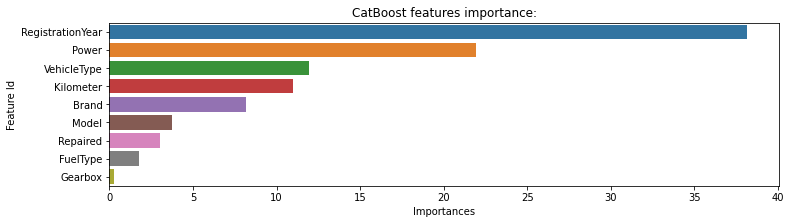

In [93]:
fi = cat_model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 3));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

In [96]:
%%time
start = time.time()
cat_pred = cat_model.predict(test[X])
cat_rmse = mean_squared_error(test[y], cat_pred) ** 0.5
end = time.time()
test_predict = end - start

CPU times: user 274 ms, sys: 6.58 ms, total: 280 ms
Wall time: 279 ms


**Итоговые результаты на тестовой выборке.**

In [97]:
print(f'RMSE модели на базе библиотеки Catboost {cat_rmse}')
print(f'Время предсказания {test_predict}')

RMSE модели на базе библиотеки Catboost 1570.9591500744568
Время предсказания 0.27863597869873047


**Проверка на адекватность**

In [ ]:
pred_const = pd.Series(y_train.mean(), index=y_test.index)
rmse_const = mean_squared_error(y_test, pred_const) ** 0.5
print(f'RMSE модели на базе константсной модели {rmse_const}')

**Вывод:** предложенная модель на базе библиотеки Catboost отвечает пороговому значению по метрике RMSE. Предсказания не занимают много времени, но вот обучение модели потребует большего времени.